Title of Project and Explanation

## Libraries <br>

In [717]:
# Pandas is required as I will be organising the data extracted from the various sources into Dataframes
import pandas as pd

# Requests is used to interact with APIs
import requests

# Numpy is used for some data filtering
import numpy as np

# Matplotlib is used to create graphics to aid in the Exploratory Data Analysis
import matplotlib.pyplot as plt

# Seaborn is used to create better formatted graphics
import seaborn as sns

# Scipy helps with tasks such as checking for skewness
from scipy.stats import skew

# XGBoost is the predictive model that this analysis shall utilise
import xgboost as xgb

# Grid Search Cross Validation is used for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# The data needs to be split into training sets and testing sets to assess model accuracy
from sklearn.model_selection import train_test_split

In [718]:
# This string is used as an argument to the IMF-related functions and serves as a reminder which period I am looking at
data_periods = '2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022'

## Functions<br>
These functions will be used throughout the script to get data through APIs and the clean it into a format from which it can be merged to the main dataset

In [719]:
def create_irena_period_data(df: pd.DataFrame, period: str, year: int, remove_country: bool =False) -> pd.DataFrame:
    """
    This function creates the IRENA dataset. This is the dataset which will contain:
    a) The target variable (change in % of renewable sources in total electricity generation)
    b) The amount of renewable electricity generation at the start of the period in question
    This function should be run twice, for both the previous and current periods, so a change in renewable % can be calculated
    :param df: The IRENA dataset in dataframe format
    :param period: 'CUR' or 'PRE' as required
    :param year: The year of observations to be extracted from the dataframe
    :param remove_country: only include the country column on one of the datasets (either 'CUR' or 'PRE') to prevent duplication of columns
    :return: Dataframe with both previous and current electricity generation data
    """
    df = df[irena_data['Year'] == year].groupby(by=['Country', 'ISO3 code', 'RE or Non-RE'])['Electricity Generation (GWh)'].sum().reset_index(name='Electricity Generation (GWh)')
    
    # Create columns for both Renewable & Non-Renewable as right now they are by row
    
    # Create the Renewable DataFrame
    renewable = df[df['RE or Non-RE'] == 'Total Renewable']
    renewable = renewable.groupby(by=['Country', 'ISO3 code'])['Electricity Generation (GWh)'].sum().reset_index()
    renewable = renewable.rename(columns={'Electricity Generation (GWh)': 'renewable'})
    
    # Create the Non-Renewable DataFrame
    non_renewable = df[df['RE or Non-RE'] == 'Total Non-Renewable']
    non_renewable = non_renewable.groupby(by=['Country', 'ISO3 code'])['Electricity Generation (GWh)'].sum().reset_index()
    non_renewable = non_renewable.rename(columns={'Electricity Generation (GWh)': 'non-renewable'})
    
    # Join them together
    grouped_irena = pd.merge(left=renewable,
                        right = non_renewable,
                        left_on=['Country', 'ISO3 code'],
                        right_on=['Country', 'ISO3 code'],
                        how='outer')
    
    # Two new fields are added which detail the total electricity generation and the percentage of this which is from renewable sources
    df = grouped_irena
    df['total_generation'] = df['renewable'] + df['non-renewable']
    df['renewable_mix'] = np.where(df['renewable'].isna(), 0,
                                   np.where(df['non-renewable'].isna(), 100, 
                                            (df['renewable'] / df['total_generation']) * 100))
    
    # Finally, columns are removed and/or renamed as required
    if remove_country:
        df = df[['Country', 'ISO3 code', 'renewable', 'renewable_mix']]
        df = df.rename(columns={'Country': 'country', 
                                'ISO3 code': 'iso3_code', 
                                'renewable': f'{period}_renewable_generation', 
                                'renewable_mix': f'{period}_renewable_mix'})
    else:
        df = df[['ISO3 code', 'renewable', 'renewable_mix']]
        df = df.rename(columns={'ISO3 code': 'iso3_code', 
                                'renewable': f'{period}_renewable_generation', 
                                'renewable_mix': f'{period}_renewable_mix'})
    
    return df

In [720]:
def get_world_bank_data(indicator: str, file_format: str, date: str) -> list:
    """
    This function connects to the World Bank API and extracts data based on arguments provided
    :param indicator: Each dataset has a corresponding indicator which is used here to direct the request to the correct endpoint
    :param file_format: Allows the user to select the format upon which the data should be returned (usually json)
    :param date: The year in question
    :return: Json file containing the required data based on the arguments
    """
    base_url = f"http://api.worldbank.org/v2/country/all/indicator/{indicator}?format={file_format}&date={date}"
    all_data = []
    page = 1
    
    # As the World Bank datasets are paginated, the function must cycle through the pages and append the data into one object
    while True:
        url = f'{base_url}&page={page}'
        response = requests.get(url)
        if response.status_code == 200:
            json_data = response.json()
            if len(json_data) >1 and json_data[1]:
                all_data.extend(json_data[1])
                page += 1
            else:
                break
        else:
            print(f'Error: {response.status_code}')
            break
            
    return all_data

In [721]:
def clean_world_bank_data(df: pd.DataFrame, value_name: str) -> pd.DataFrame:
    """
    This functions takes World Bank dataset and cleans/transforms it, ready to be merged to the main dataset
    :param df: World Bank dataset as required
    :param value_name: the default column name is 'value'. This needs to be updated to something more descriptive
    :return: Cleaned dataset
    """
    # Remove unneeded columns
    df = df[['countryiso3code', 'value']]
    
    # Format cells as required
    df['countryiso3code'] = df['countryiso3code'].astype(str)
    
    # Remove Nans and null values from the dataset
    df = df.dropna(subset = ['value'])
    
    # Rename columns
    df = df.rename(columns={'countryiso3code': 'iso3_code', 'value': value_name})
    
    return df

In [722]:
def get_imf_data(indicator: str, date: str) -> dict:
    """
    This function connects to the World Bank API and extracts data based on arguments provided
    :param indicator: Each dataset has a corresponding indicator which is used here to direct the request to the correct endpoint
    :param date: The year in question
    :return: Json file containing the required data based on the arguments
    """
    url = f"https://www.imf.org/external/datamapper/api/v1/{indicator}?periods={date}"
    response = requests.get(url)
    if response.status_code == 200:
        json_data = response.json()
        return json_data['values'][indicator]
    else:
        raise ValueError(f"error getting response from {url}: {response.status_code}")

In [723]:
def clean_imf_data(retrieved_data: dict) -> pd.DataFrame:
    """
    This functions takes IMF dataset and cleans/transforms it, ready to be merged to the main dataset.
    :param retrieved_data: IMF dataset as required.
    :return: Cleaned IMF dataset, ready to merged with the main dataset.
    """
    country_rows = []
    for country, years in retrieved_data.items():
        country_data = {'iso3_code': country}
        country_data.update(years)
        country_rows.append(country_data)
        
    return pd.DataFrame(country_rows)

## Step 1: Retrieve, Clean and Transform the IRENA dataset

In [724]:
irena_data = pd.read_excel(
    io=r'C:\Users\User\OneDrive\Documents\prof_practice\irena_energy_stats_2024.xlsx',
    sheet_name='Country'
)

In [725]:
# Create a dataframe for both comparison periods are required
pre_irena = create_irena_period_data(irena_data, 'pre',2013, False)
cur_irena = create_irena_period_data(irena_data, 'cur', 2022, True)

# Combine the periods into a single dataset
final_irena = pd.merge(left=pre_irena,
                       right=cur_irena,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

# Create the target variable
final_irena['renewable_mix_change'] = final_irena['cur_renewable_mix'] - final_irena['pre_renewable_mix']

# Rename the columns
final_irena = final_irena[['country', 'iso3_code', 'pre_renewable_generation', 'renewable_mix_change']]

## Step 2: Add Median Age data from the World Health Organisation

In [726]:
# Import data from an XLSX file
who_data = pd.read_excel(io=r'C:\Users\User\OneDrive\Documents\prof_practice\who_median_age.xlsx', sheet_name='Data')

# Filter for the year required
who_data = who_data[who_data['Year'] == 2022]

# Remove unneeded columns
who_data = who_data[['Country ISO 3 code', 'Value Numeric']]

# Rename columns as required
who_data = who_data.rename(columns={'Country ISO 3 code': 'iso3_code', 'Value Numeric': 'median_age'})

In [727]:
# Combine the IRENA and WHO Datasets
complete_dataset = pd.merge(left=final_irena,
                       right=who_data,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

## Step 3: Add GDP per Capita and Compulsory Education data from the World Bank

In [728]:
# Use the World Bank API to return the GDP Per Capita dataset
gdp_per_capita = pd.DataFrame.from_records(get_world_bank_data('NY.GDP.PCAP.CD', 'json', '2022'))

# Clean and format the data
gdp_per_capita = clean_world_bank_data(gdp_per_capita, 'gdp_per_capita')

# Add the dataset to the main DataFrame
complete_dataset = pd.merge(left=complete_dataset,
                       right=gdp_per_capita,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

C:\Users\User\AppData\Local\Temp\ipykernel_11644\1452728300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countryiso3code'] = df['countryiso3code'].astype(str)


In [729]:
# Use the World Bank API to return the Compulsory Education dataset
comp_edu = pd.DataFrame.from_records(get_world_bank_data('SE.COM.DURS', 'json', '2022'))

# Clean and format the data
comp_edu = clean_world_bank_data(comp_edu, 'compulsory_education')

# Add the dataset to the main DataFrame
complete_dataset = pd.merge(left=complete_dataset,
                       right=comp_edu,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

C:\Users\User\AppData\Local\Temp\ipykernel_11644\1452728300.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countryiso3code'] = df['countryiso3code'].astype(str)


## Step 4: Add Average Inflation, average Central Gov Debt and AI Preparedness data from the IMF

In [730]:
# Retrieve and clean the data
inflation_json = get_imf_data('PCPIPCH', data_periods)
inflation_data = clean_imf_data(inflation_json)

# Calculate the metric average over the period in question
inflation_data['average_inflation'] = inflation_data.iloc[:, 1:].mean(axis=1)
final_inflation = inflation_data[['iso3_code', 'average_inflation']]

# Add the dataset to the main DataFrame
complete_dataset = pd.merge(left=complete_dataset,
                       right=final_inflation,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

In [731]:
# Retrieve and clean the data
cg_debt_json = get_imf_data('CG_DEBT_GDP', data_periods)
cg_debt_data = clean_imf_data(cg_debt_json)

# Calculate the metric average over the period in question
cg_debt_data['average_net_debt'] = cg_debt_data.iloc[:, 1:].mean(axis=1)
final_cg_debt = cg_debt_data[['iso3_code', 'average_net_debt']]

# Add the dataset to the main DataFrame
complete_dataset = pd.merge(left=complete_dataset,
                       right=final_cg_debt,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

In [732]:
# Retrieve and clean the data
ai_json = get_imf_data('AI_PI', '2023')
ai_data = clean_imf_data(ai_json)

final_ai = ai_data.rename(columns={'2023': 'ai_preparedness'})

# Add the dataset to the main DataFrame
complete_dataset = pd.merge(left=complete_dataset,
                       right=final_ai,
                       left_on=['iso3_code'],
                       right_on=['iso3_code'],
                       how='inner')

## Step 5: Prepare the Completed Dataset

In [733]:
complete_dataset = complete_dataset[['country', 'gdp_per_capita', 'average_net_debt', 'average_inflation', 'median_age', 'compulsory_education', 'ai_preparedness', 'pre_renewable_generation', 'renewable_mix_change']]

In [734]:
complete_dataset

,country,gdp_per_capita,average_net_debt,average_inflation,median_age,compulsory_education,ai_preparedness,pre_renewable_generation,renewable_mix_change
0,Albania,6846.426143,69.731980,2.240000,35.943,9.0,0.526793,6960.030,0.000000
1,Algeria,4961.552577,28.773215,4.820000,27.983,10.0,0.370439,291.017,0.462285
2,Angola,2929.694455,67.575514,19.200000,16.390,10.0,0.259659,3638.585,30.309684
3,Argentina,13935.681111,69.525114,40.985714,31.739,14.0,0.473809,35092.719,4.005632
4,Armenia,6571.974455,53.822150,3.300000,35.815,12.0,0.492887,2177.200,8.447566
...,...,...,...,...,...,...,...,...,...
138,Uruguay,20691.973899,46.360337,8.410000,35.496,14.0,0.548641,9029.879,7.170168
139,Viet Nam,4116.385761,38.765303,3.200000,31.938,10.0,0.481869,58466.294,4.961942
140,Yemen,615.702079,72.253465,22.490000,18.118,9.0,0.253328,4.589,17.205222
141,Zambia,1447.123101,76.320599,11.480000,17.288,7.0,0.370720,13348.817,-10.947247


## Step 6: Check for Skewness and Scaling Issues

Skewness can affect the accuracy of many predictive models. They can hide and/or distort feature relationships and in some cases violate the central assumptions of some predictive techniques.

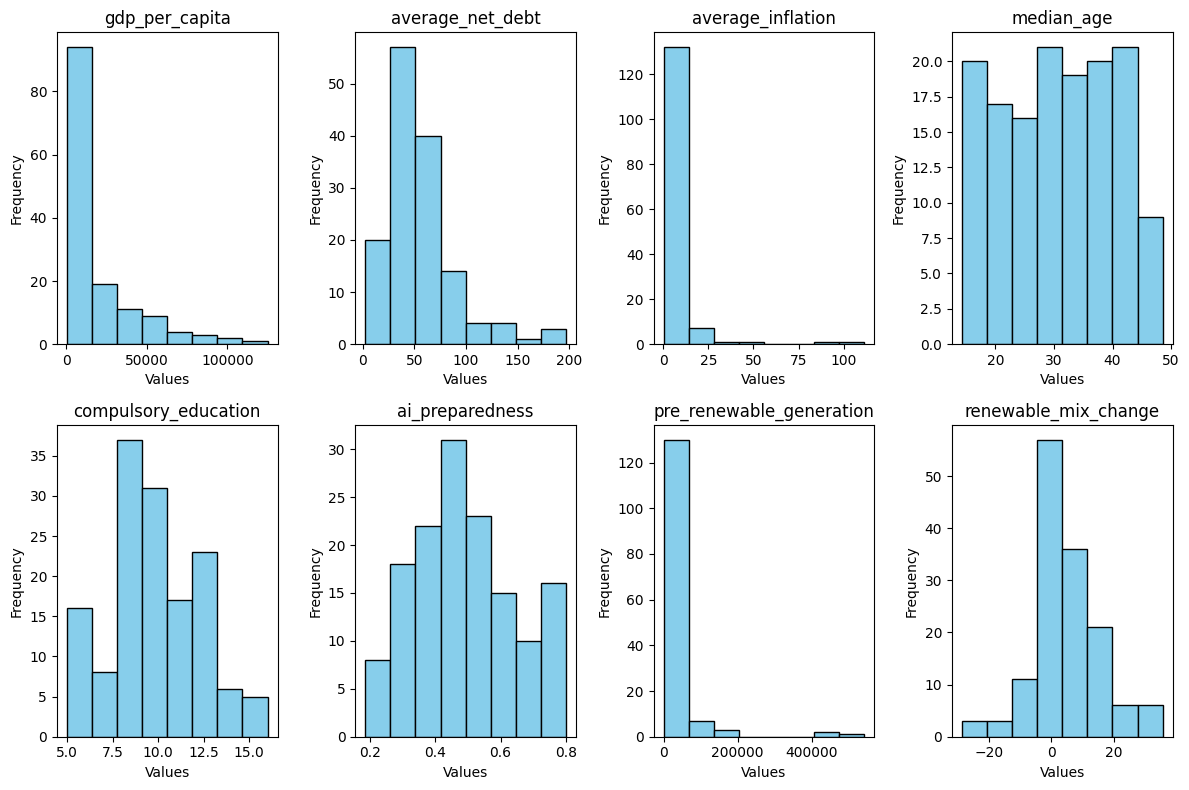

In [735]:
def create_grid_plot(df: pd.DataFrame) -> None:
    features = df.columns[1:]
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8)) 
    axes = axes.ravel()
    
    # Create histograms for each feature
    for i, feature in enumerate(features):
        axes[i].hist(df[feature], bins=8, color='skyblue', edgecolor='black')
        axes[i].set_title(feature)
        axes[i].set_xlabel('Values')
        axes[i].set_ylabel('Frequency')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

create_grid_plot(complete_dataset)

Average inflation and pre renewable generation all appear to be skewed.
np.skew will be used to confirm this

In [736]:
for column in complete_dataset.columns:
    if column != 'country':
        print(f'skewness of {column} is {skew(complete_dataset[column])}')
    else:
        pass    

skewness of gdp_per_capita is 2.0525563972792598
skewness of average_net_debt is 1.7417237321969348
skewness of average_inflation is 5.923191867886571
skewness of median_age is 0.00515284512836217
skewness of compulsory_education is 0.08846083683795267
skewness of ai_preparedness is 0.275016252296738
skewness of pre_renewable_generation is 5.0444373969789655
skewness of renewable_mix_change is 0.23788234193535193


This confirms the skewness. Logarithmic transformation will therefore be used to alleviate the skew.

In [737]:
transformed_dataset = complete_dataset
transformed_dataset['average_inflation'] = np.log(transformed_dataset['average_inflation'] + 0.001)
transformed_dataset['pre_renewable_generation'] = np.log(transformed_dataset['pre_renewable_generation'] + 0.001)
transformed_dataset['average_net_debt'] = np.log(transformed_dataset['average_net_debt'] + 0.001)
transformed_dataset['gdp_per_capita'] = np.log(transformed_dataset['gdp_per_capita'] + 0.001)

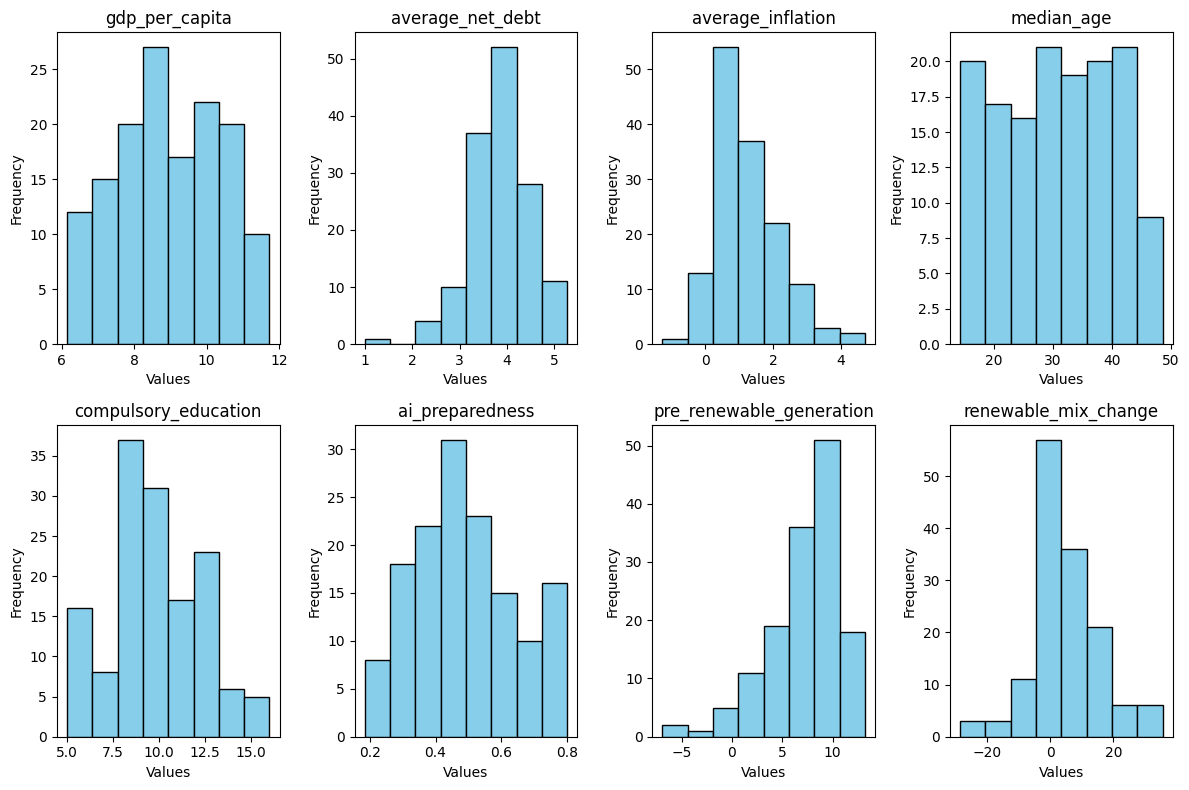

In [738]:
create_grid_plot(transformed_dataset)

In [739]:
for column in transformed_dataset.columns:
    if column != 'country':
        print(f'skewness of {column} is {skew(transformed_dataset[column])}')
    else:
        pass    

skewness of gdp_per_capita is -0.020461497130067393
skewness of average_net_debt is -0.8540208825412654
skewness of average_inflation is 0.8588361559311514
skewness of median_age is 0.00515284512836217
skewness of compulsory_education is 0.08846083683795267
skewness of ai_preparedness is 0.275016252296738
skewness of pre_renewable_generation is -1.2121611269055264
skewness of renewable_mix_change is 0.23788234193535193


This has corrected the largest instances of skewness in the data

## Step 7: Check for Multicollinearity

Multicollinearity - or correlations existing between features - needs to be neutralised in order to run an accurate prediction

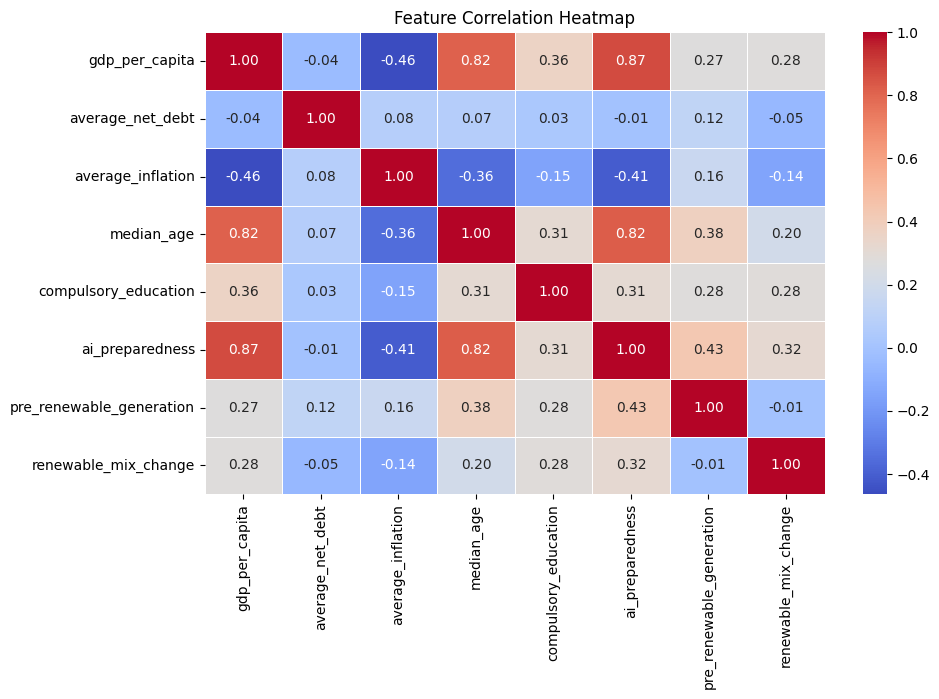

In [740]:
# Compute the correlation matrix
corr_matrix = transformed_dataset.iloc[:, 1:].corr()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")
plt.show()

This shows the presence of moderate correlation between AI preparedness and GDP per Capita and Median Age. For this reason it is discarded from the dataset.

In [741]:
transformed_dataset = transformed_dataset.drop(columns='ai_preparedness')

## Step 8: Create an Interaction Feature
It is possible that countries with a high net debt also experience higher inflation levels due to increased levels of macroeconomic stress. An interaction feature will be added to capture this possible synergistic relationship.

In [742]:
transformed_dataset['inflation_x_debt'] = transformed_dataset['average_inflation'] * transformed_dataset['average_net_debt']

## Step 9: Create a Train/Test Split

In [743]:
# Define the feature variables
features = ['gdp_per_capita', 'average_net_debt', 'average_inflation', 'median_age', 'compulsory_education', 'pre_renewable_generation', 'inflation_x_debt']

#Define the target variables
target = 'renewable_mix_change'

X = transformed_dataset[features]
y = transformed_dataset[target] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Step 10: Perform Hyperparameter Tuning
Tune the parameter on the XGBoost model to ensure the best accuracy

In [750]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03],
    'max_depth': [2, 3, 5],
    'n_estimators': [3, 5, 7]
}

# Initialise XGBoost model
xgb_model = xgb.XGBRegressor()

# Set up GridSearch with Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 3}
Best Score: -11.906013816862945
